## TODO:

1. incorporate `PrettyDuration` into `JagularFileMap` and update `__repr__` [DONE!]
1. split out `pairwise` and `is_sorted` to `utils` [DONE!]
1. fix issue of `header_size`
1. fix test data [DONE!]
1. write actual utiity function to return data and/or list of required files
1. finish `NotImplementedError` functions
1. deal with duplicates, and overlaps
1. consider graceful abort?
1. FFB! Provide way to request specific channel(s) and provide for inter-file interpolation (default should maybe return all channels?)
1. ...?

In [34]:
import struct
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [35]:
import jagular as jag

In [36]:
file_list = ['../sample_data/sample_data_1.rec',
             '../sample_data/sample_data_3.rec',
             '../sample_data/sample_data_4.rec',
             '../sample_data/sample_data_5.rec',
             '../sample_data/sample_data_2.rec'
            ]

jfm = jag.io.JagularFileMap(file_list)

print(jfm)

<JagularFileMap: 5 files spanning 9:45:54:849 hours (missing 52:19:480 minutes)> at 0x7fbf5653bb70


In [37]:
ch_out_prefix = '2017-05-31_16-11-39_'
n_chan_zfill = len(str(jfm._reader.n_spike_channels))
ch_out_files = [ch_out_prefix + 'ch.' + str(n).zfill(n_chan_zfill) + '.raw' for n in range(jfm._reader.n_spike_channels)]
# print(ch_out_files)

In [38]:
#TODO: make filenames configurable
#TODO: warn if files already exist, or if we cannot create them (this latter one should be handled automatically)

from contextlib import ExitStack

with ExitStack() as stack:
    ts_file = stack.enter_context(open('timestamps.raw', 'wb+'))
    ch_files = [stack.enter_context(open(fname, 'wb+')) for fname in ch_out_files]
    
    for ii, (ts, all_ch_data) in enumerate(jfm.read_stitched_files(block_size=4)):
        num_packets = len(ts)

        my_ts_struct = struct.Struct('<%dI' % num_packets)
        my_ch_struct = struct.Struct('<%dh' % num_packets)
        ts_packed = my_ts_struct.pack(*ts)
        for ch in range(jfm._reader.n_spike_channels):
            ch_packed = my_ch_struct.pack(*all_ch_data[ch,:])
            # write current channel data of current block to file:
            ch_files[ch].write(ch_packed)
            
        # write timestamps of current block to file:
        ts_file.write(ts_packed)       


In [39]:
# now try to read back some data:

ts_from_file = np.fromfile('timestamps.raw', dtype=np.uint32)

In [40]:
ts_from_file

array([    200917,   55205700,   55205701,   55205702,   55205703,
         55205704,   55205705,   55205706,   55205707,   55205708,
        190383308,  216003235,   45380179,   45380180,   45380181,
         45380182,   45380183,   45380184,   45380185,   45380186,
         45380187,  430419684,  428619684,   55912384,   55912385,
         55912386,   55912387,   55912388,   55912389,   55912390,
         55912391,   55912392,  617928812,  648279793,   23871545,
         23871546,   23871547,   23871548,   23871549,   23871550,
         23871551,   23871552,   23871553,  824383837,  864397337,
         23104817,   23104818,   23104819,   23104820,   23104821,
         23104822,   23104823,   23104824,   23104825, 1054846413], dtype=uint32)

In [47]:
for ii, (ts, ch_data) in enumerate(jfm.read_stitched_files(block_size=5)):
    print(ii, ts)

0 [200917, 55205700, 55205701, 55205702, 55205703]
1 [55205704, 55205705, 55205706, 55205707, 55205708]
2 [190383308, 216003235, 45380179, 45380180, 45380181]
3 [45380182, 45380183, 45380184, 45380185, 45380186]
4 [45380187, 430419684, 428619684, 55912384, 55912385]
5 [55912386, 55912387, 55912388, 55912389, 55912390]
6 [55912391, 55912392, 617928812, 648279793, 23871545]
7 [23871546, 23871547, 23871548, 23871549, 23871550]
8 [23871551, 23871552, 23871553, 824383837, 864397337]
9 [23104817, 23104818, 23104819, 23104820, 23104821]
10 [23104822, 23104823, 23104824, 23104825, 1054846413]


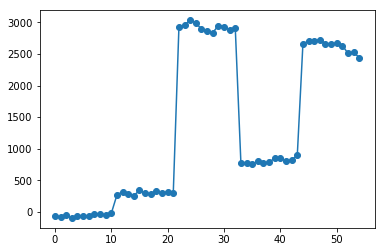

In [215]:
# load unfiltered data ASSUMING CONTINUOUS
fmt='<i'
x = np.fromfile('2017-05-31_16-11-39_ch.00.raw', dtype=np.int16)
plt.plot(x, marker='o')

In [ ]:
memmap()

In [125]:
from scipy.signal import filtfilt, iirdesign
from numpy import memmap

def butterfilt(finname, foutname, fmt, fs, fl=5.0, fh=100.0, gpass=1.0, gstop=30.0, ftype='butter', buffer_len=100000, overlap_len=100, max_len=-1):
    """Given sampling frequency, low and high pass frequencies design a butterworth filter, and filter our data with it."""
    fso2 = fs/2.0
    wp = [fl/fso2, fh/fso2]
    ws = [0.8*fl/fso2,1.4*fh/fso2]
    b, a = iirdesign(wp, ws, gpass=gpass, gstop=gstop, ftype=ftype, output='ba')
    y = filtfiltlong(finname, foutname, fmt, b, a, buffer_len, overlap_len, max_len)
    return y, b, a

def filtfiltlong(finname, foutname, fmt, b, a, buffer_len=100000, overlap_len=100, max_len=-1):
    """Use memmap and chunking to filter continuous data.
    Inputs:
    finname -
    foutname    -
    fmt         - data format eg 'i'
    b,a         - filter coefficients
    buffer_len  - how much data to process at a time
    overlap_len - how much data do we add to the end of each chunk to smooth out filter transients
    max_len     - how many samples to process. If set to -1, processes the whole file
    Outputs:
    y           - The memmapped array pointing to the written file
    Notes on algorithm:
    1. The arrays are memmapped, so we let pylab (numpy) take care of handling large arrays
    2. The filtering is done in chunks:
    Chunking details:
                |<------- b1 ------->||<------- b2 ------->|
    -----[------*--------------{-----*------]--------------*------}----------
            |<-------------- c1 -------------->|
                                |<-------------- c2 -------------->|
    From the array of data we cut out contiguous buffers (b1,b2,...) and to each buffer we add some extra overlap to
    make chunks (c1,c2). The overlap helps to remove the transients from the filtering which would otherwise appear at
    each buffer boundary.
    """
    x = memmap(finname, dtype=fmt, mode='r')
    if max_len == -1:
        max_len = x.size
    y = memmap(foutname, dtype=fmt, mode='w+', shape=max_len)

    for buff_st_idx in range(0, max_len, buffer_len):
        chk_st_idx = max(0, buff_st_idx - overlap_len)
        buff_nd_idx = min(max_len, buff_st_idx + buffer_len)
        chk_nd_idx = min(x.size, buff_nd_idx + overlap_len)
        rel_st_idx = buff_st_idx - chk_st_idx
        rel_nd_idx = buff_nd_idx - chk_st_idx
        print('filtering {}--{}'.format(chk_st_idx, chk_nd_idx))
        print('saving {}--{}'.format(buff_st_idx, buff_nd_idx))
        this_y_chk = filtfilt(b, a, x[chk_st_idx:chk_nd_idx], method="gust")
        y[buff_st_idx:buff_nd_idx] = this_y_chk[rel_st_idx:rel_nd_idx]

    return y

filtering 0--15
saving 0--10
filtering 5--25
saving 10--20
filtering 15--35
saving 20--30
filtering 25--45
saving 30--40
filtering 35--55
saving 40--50
filtering 45--55
saving 50--55


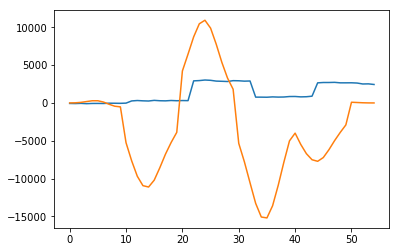

In [214]:
y, b, a = butterfilt(finname='2017-05-31_16-11-39_ch.00.raw', buffer_len=10,
                     foutname='filtered.raw',
                     fmt=np.int16,
                     fs=30000,
                     fl=500,
                     fh=8000,
                     overlap_len=5)

plt.plot(x)
plt.plot(y)

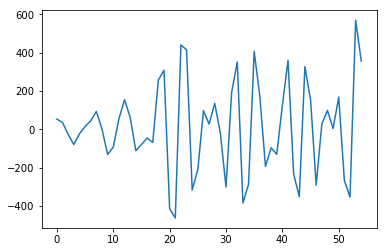

In [146]:
tim

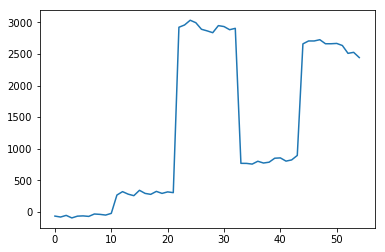

In [78]:
y = memmap('2017-05-31_16-11-39_ch.00.raw', dtype=np.int16)
plt.plot(y)

In [ ]:
# AllDataArr = np.memmap('',dtype=np.int16,shape=(n_samples,n_ch_dat),mode='r')
# b,a = signal.butter(3,100./(SAMPLE_RATE/2),'high') #filter at 100 Hz
# IntraArr = AllDataArr[:,IntraChannel].copy()
# IntraArr = signal.filtfilt(b,a,IntraArr)
# Thresh = IntraArr.max()*THRESH_FRAC

In [45]:
import struct

ch = 5

ch_data = all_ch_data[ch,:]  # get a 1-D array of numbers
arrSize = len(ch_data)

my_struct = struct.Struct('<%dh' % arrSize)

# packed = struct.pack('<iiHHi%df' % arrSize,
#     nSamples, nSampPeriod, nSampSize, nParmKind, arrSize, *flattened)

In [ ]:
flattened = npVect.ravel()  # get a 1-D array of numbers
arrSize = len(flattened)
# pack header, count of numbers, and numbers, all in one call
packed = struct.pack('<iiHHi%df' % arrSize,
    nSamples, nSampPeriod, nSampSize, nParmKind, arrSize, *flattened)

In [16]:
from contextlib import ExitStack

with ExitStack() as stack:
    files = [stack.enter_context(open(fname, 'wb+')) for fname in ch_out_files]
    
    
    flattened = npVect.ravel()  # get a 1-D array of numbers
arrSize = len(flattened)
# pack header, count of numbers, and numbers, all in one call
packed = struct.pack('<iiHHi%df' % arrSize,
    nSamples, nSampPeriod, nSampSize, nParmKind, arrSize, *flattened)

['ch.0000.raw',
 'ch.0001.raw',
 'ch.0002.raw',
 'ch.0003.raw',
 'ch.0004.raw',
 'ch.0005.raw',
 'ch.0006.raw',
 'ch.0007.raw',
 'ch.0008.raw',
 'ch.0009.raw',
 'ch.0010.raw',
 'ch.0011.raw',
 'ch.0012.raw',
 'ch.0013.raw',
 'ch.0014.raw',
 'ch.0015.raw',
 'ch.0016.raw',
 'ch.0017.raw',
 'ch.0018.raw',
 'ch.0019.raw',
 'ch.0020.raw',
 'ch.0021.raw',
 'ch.0022.raw',
 'ch.0023.raw',
 'ch.0024.raw',
 'ch.0025.raw',
 'ch.0026.raw',
 'ch.0027.raw',
 'ch.0028.raw',
 'ch.0029.raw',
 'ch.0030.raw',
 'ch.0031.raw',
 'ch.0032.raw',
 'ch.0033.raw',
 'ch.0034.raw',
 'ch.0035.raw',
 'ch.0036.raw',
 'ch.0037.raw',
 'ch.0038.raw',
 'ch.0039.raw',
 'ch.0040.raw',
 'ch.0041.raw',
 'ch.0042.raw',
 'ch.0043.raw',
 'ch.0044.raw',
 'ch.0045.raw',
 'ch.0046.raw',
 'ch.0047.raw',
 'ch.0048.raw',
 'ch.0049.raw',
 'ch.0050.raw',
 'ch.0051.raw',
 'ch.0052.raw',
 'ch.0053.raw',
 'ch.0054.raw',
 'ch.0055.raw',
 'ch.0056.raw',
 'ch.0057.raw',
 'ch.0058.raw',
 'ch.0059.raw',
 'ch.0060.raw',
 'ch.0061.raw',
 'ch.006

In [6]:

for ii, (ts, ch_data) in enumerate(jfm.read_stitched_files(block_size=5)):
    print(ii, ts)

0 [200917, 55205700, 55205701, 55205702, 55205703]
1 [55205704, 55205705, 55205706, 55205707, 55205708]
2 [190383308, 216003235, 45380179, 45380180, 45380181]
3 [45380182, 45380183, 45380184, 45380185, 45380186]
4 [45380187, 430419684, 428619684, 55912384, 55912385]
5 [55912386, 55912387, 55912388, 55912389, 55912390]
6 [55912391, 55912392, 617928812, 648279793, 23871545]
7 [23871546, 23871547, 23871548, 23871549, 23871550]
8 [23871551, 23871552, 23871553, 824383837, 864397337]
9 [23104817, 23104818, 23104819, 23104820, 23104821]
10 [23104822, 23104823, 23104824, 23104825, 1054846413]


In [28]:
jag.io.JagularFileMap('../sample_data/sample_data_1.rec')

<JagularFileMap: 1 files spanning 1:45:39:413 hours (missing 0.0 milliseconds)> at 0x1f92107c278

In [29]:
jfm.timestamps

array([[  6.69723333e+00,   6.34611027e+03],
       [  7.20010783e+03,   1.43473228e+04],
       [  1.42873228e+04,   2.05976271e+04],
       [  2.16093264e+04,   2.74794612e+04],
       [  2.88132446e+04,   3.51615471e+04]])

In [30]:
jfm.timesamples

array([[    200917,  190383308],
       [ 216003235,  430419684],
       [ 428619684,  617928812],
       [ 648279793,  824383837],
       [ 864397337, 1054846413]])

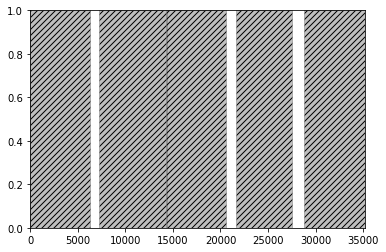

In [31]:
ax = jfm.plot()
# ax.set_xlim(0, 300);

In [32]:
jfm._samples_within_bounds(2853122, 7093204 )

True

In [33]:
jfm._time_within_bounds(100, 250)

True

In [34]:
print("duration including gaps: {}".format(jfm.duration_w_gaps))
print("duration excluding gaps: {}".format(jfm.duration_wo_gaps))

duration including gaps: 9:45:54:849 hours
duration excluding gaps: 8:53:35:369 hours


In [83]:
from contextlib import ExitStack

with open('test1', 'w') as f:
    f.write('f1b1f1b2f1b3f1b4')
    
with open('test2', 'w') as f:
    f.write('f2b1f2b2f2b3f2b4')
    
with open('test3', 'w') as f:
    f.write('f3b1f3b2')
    
with open('test4', 'w') as f:
    f.write('f4b1f4b2f4b3f4b4f4b5')
    
filenames = ['test1', 'test2', 'test3', 'test4']

from contextlib import ExitStack

def read_stitched_files(nch=2):
    with ExitStack() as stack:
        files = [stack.enter_context(open(fname, 'r')) for fname in filenames]
        ii=0
        while True:
            try:
                chunk = files[ii].read(4*nch)
                if 0 < len(chunk) < 4*nch:
                    # chunk size could not be filled from current file, so move onto next file
                    ii+=1
                    chunkB = files[ii].read(4*int(nch-len(chunk)/4))
                    chunk = chunk + chunkB
                if chunk:
                    yield chunk
                else:
                    ii+=1
            except IndexError:
                return
                       
for chunk in read_stitched_files(3):
    print(chunk)

f1b1f1b2f1b3
f1b4f2b1f2b2
f2b3f2b4f3b1
f3b2f4b1f4b2
f4b3f4b4f4b5


In [82]:
with open('test1', 'w') as f:
    f.write('f1b1f1b2f1b3f1b4')
with open('test2', 'w') as f:
    f.write('f2b1f2b2f2b3f2b4')
with open('test3', 'w') as f:
    f.write('f3b1f3b2')   
with open('test4', 'w') as f:
    f.write('f4b1f4b2f4b3f4b4f4b5')

print('')
print('One symbol at a time:')
print('=======================')
for chunk in read_stitched_files(1):
    print(chunk)
    
print('')
print('Two symbols at a time:')
print('=======================')
for chunk in read_stitched_files(2):
    print(chunk)
    
print('')
print('Three symbols at a time:')
print('=======================')
for chunk in read_stitched_files(3):
    print(chunk)
    
print('')
print('Four symbols at a time:')
print('=======================')
for chunk in read_stitched_files(4):
    print(chunk)
    
print('')
print('Five symbols at a time:')
print('=======================')
for chunk in read_stitched_files(5):
    print(chunk)
    
print('')
print('Six symbols at a time:')
print('=======================')
for chunk in read_stitched_files(6):
    print(chunk)


One symbol at a time:
f1b1
f1b2
f1b3
f1b4
f2b1
f2b2
f2b3
f2b4
f3b1
f3b2
f4b1
f4b2
f4b3
f4b4
f4b5

Two symbols at a time:
f1b1f1b2
f1b3f1b4
f2b1f2b2
f2b3f2b4
f3b1f3b2
f4b1f4b2
f4b3f4b4

Three symbols at a time:
f1b1f1b2f1b3
f1b4f2b1f2b2
f2b3f2b4f3b1
f3b2f4b1f4b2
f4b3f4b4f4b5

Four symbols at a time:
f1b1f1b2f1b3f1b4
f2b1f2b2f2b3f2b4
f3b1f3b2f4b1f4b2

Five symbols at a time:
f1b1f1b2f1b3f1b4f2b1
f2b2f2b3f2b4f3b1f3b2
f4b1f4b2f4b3f4b4f4b5

Six symbols at a time:
f1b1f1b2f1b3f1b4f2b1f2b2
f2b3f2b4f3b1f3b2
